# Volatility Arbitrage Strategy

In [1]:
# import necessary libraries
import pandas as pd

# import class object under Code folder
from Code.data_cleaning import data_cleaning
from Code.implied_vol import BS_implied_vol
from Code.fit_bs import fit_BS

## Data Cleaning

- retrieve spx option data from Bloomberg
- retrieve spx index data from yhoo finance
- clean data
  - unnecessary rows and columns
  - option ticker breakdown
  - expiration date format
  - keep options with certain expiration date which have more than 10 implied volatility
  - save the term structure of options
  - use the mid price of bid and ask as the option price
  - only use SPX data not SPXW data


In [2]:
option_data_spx = pd.read_csv('./Public/Data/Option/spx_option_0901.csv')
option_data_spx = data_cleaning(option_data_spx).format_data(index = 'SPX')
option_data = data_cleaning(option_data_spx).check_iv_number(drop_type='volume', drop_threshold=10)
spx_data = data_cleaning(option_data_spx).get_hist('SPX', '2021-09-01', '2023-11-13')
option_price = data_cleaning(option_data_spx).extract_option_price(px_type='mid')

display(option_data.head())
display(spx_data.head())
display(option_price.head())

,Ticker,Index,Type,Expiry,Strike,Bid,Ask,Last,Volm,IVM
0,SPX 9/15/23 C4470,SPX,C,2023-09-15,4470,66.699997,67.699997,68.380005,16.0,10.665597
1,SPX 9/15/23 C4475,SPX,C,2023-09-15,4475,62.900009,63.900009,61.449997,18.0,10.570473
2,SPX 9/15/23 C4490,SPX,C,2023-09-15,4490,52.000000,53.000000,52.119995,11.0,10.279760
3,SPX 9/15/23 C4495,SPX,C,2023-09-15,4495,48.599991,49.599991,48.669998,6.0,10.197698
4,SPX 9/15/23 C4500,SPX,C,2023-09-15,4500,45.300003,46.300003,45.800003,7161.0,10.115258


,Open
Date,
2021-09-01,4528.799805
2021-09-02,4534.479980
2021-09-03,4532.419922
2021-09-07,4535.379883
2021-09-08,4518.089844


,Index,Strike,Expiry,c,p
0,SPX,4470,2023-09-15,67.199997,16.199997
1,SPX,4475,2023-09-15,63.400009,17.400002
2,SPX,4490,2023-09-15,52.500000,21.449997
3,SPX,4495,2023-09-15,49.099991,23.000000
4,SPX,4500,2023-09-15,45.800003,24.699997


## Find BS Implied Volatility

- use put-call parity to calculate the risk-free rate and dividend yield for spx index option
  - for different expiration date, the implied risk-free rate are different. 
    $$
    C-P = S_0e^{-qT}-Ke^{-rT}\\
    C-P = e^{-rT}(S_0e^{(r-q)T}-K) = e^{-r}(F_{(0, T)}-K)\\
    \text{where }F_{(0,T)}:=S_0e^{(r-q)T}, \text{ which is the forward price at time 0 with maturity T. }
    $$
  - get rid of outlier and abnormal value, implied risk-free rate are the average of the rest
    $$
      r_{risk-free, implied} = \frac{1}{N}\sum_{i=1}^N r_i, \quad r_i \in [r_{min}, r_{max}]
    $$
- use Black-Scholes model to calculate the implied volatility for each option
  - Black-Scholes model using forward price, the formula is:
    $$
    C(t) = e^{-r(T-t)}(F_{(t, T)}\Phi(d_1)-K\Phi(d_2))\\
    P(t) = e^{-r(T-t)}(K\Phi(-d_2)-F_{(t, T)}\Phi(-d_1))\\
    \displaystyle\text{where }d_1 = \frac{\ln(\frac{F_{(t, T)}}{K})+\frac{1}{2}\sigma^2T}{\sigma\sqrt{T}},\quad d_2 = d_1-\sigma\sqrt{T}, \quad \phi() \text{ is the standard normal pdf}\\
    \text{and }F_{(t, T)}:=S_0e^{(r-q)(T-t)}, \text{ which is the forward price at time 0 with maturity T. }
    
    $$
  - Use bisection method to get the implied volatility.   
    $$
      \sigma_{implied}(F_{(0, T)}, K, T, r, c) = \sigma_{implied}(F_{(0, T)}, K, T, r, p)\\
    $$


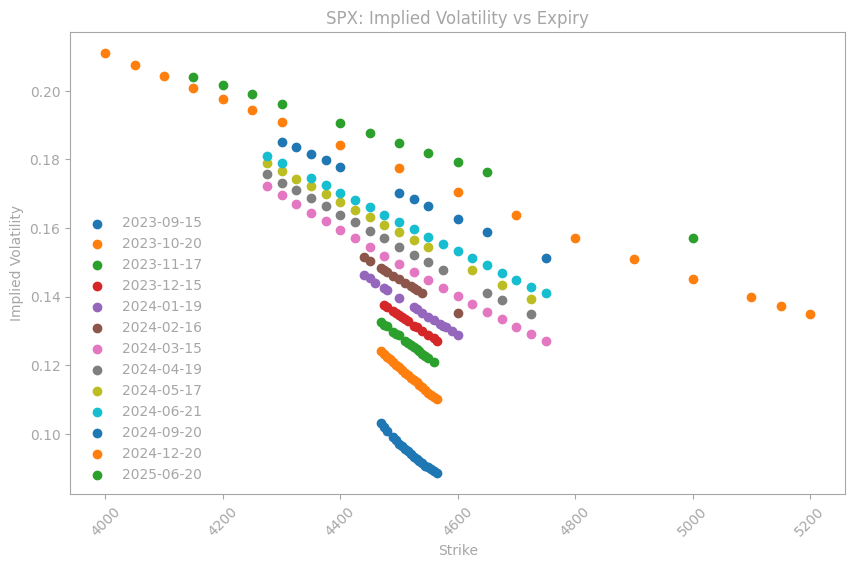

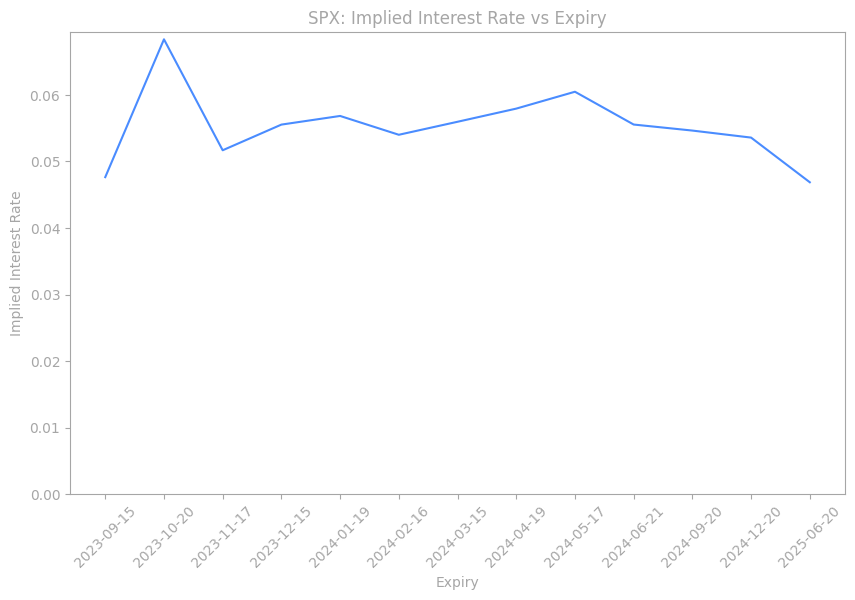

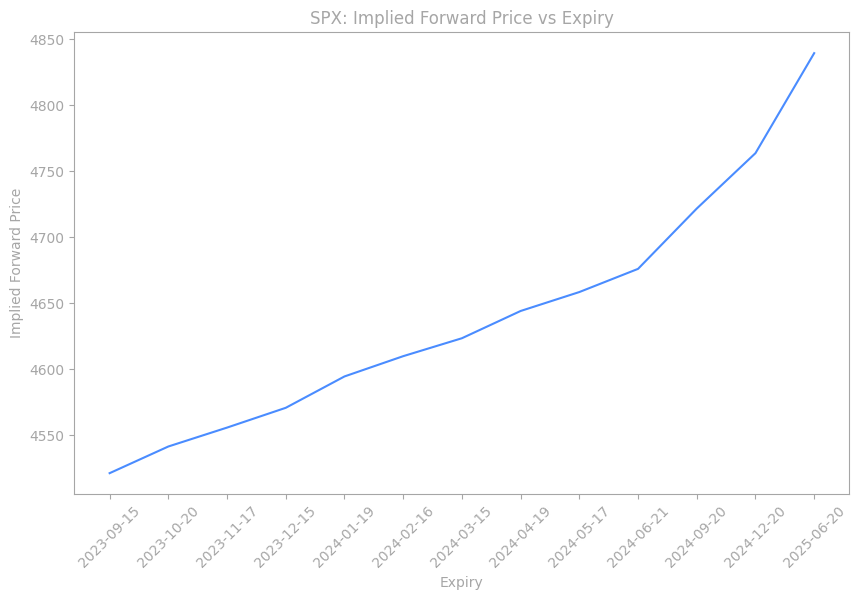

,Index,Expiry,implied_ir,implied_fwd
0,SPX,2023-09-15,0.047637,4521.109987
1,SPX,2023-10-20,0.068348,4541.318062
2,SPX,2023-11-17,0.051676,4555.645512
3,SPX,2023-12-15,0.055533,4570.635823
4,SPX,2024-01-19,0.056832,4594.397578


,4000,4050,4100,4150,4200,4250,4275,4300,4325,4350,...,4675,4700,4725,4750,4800,4900,5000,5100,5150,5200
2023-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-15,NaN,NaN,NaN,NaN,NaN,NaN,0.172161,0.169514,0.167037,0.164475,...,0.133388,0.131137,0.129167,0.12712,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-19,NaN,NaN,NaN,NaN,NaN,NaN,0.175833,0.173271,0.171136,0.16866,...,0.138946,NaN,0.134866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-17,NaN,NaN,NaN,NaN,NaN,NaN,0.178907,0.176601,0.174381,0.172161,...,0.143448,NaN,0.139368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-21,NaN,NaN,NaN,NaN,NaN,NaN,0.180871,0.178821,NaN,0.174552,...,0.14693,0.144925,0.142815,0.140915,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
implied_params = BS_implied_vol(option_price).parity_implied_params(option_data, plot_parity=False)
implied_vol = BS_implied_vol(option_price[option_price['Index'] == 'SPX']).get_iv(option_data[option_data['Index'] == 'SPX'], implied_params[implied_params['Index'] == 'SPX'], plot_iv_scatter=True)
BS_implied_vol(option_price).plot_ir(implied_params)
BS_implied_vol(option_price).plot_fwd(implied_params)

display(implied_params.head())
display(implied_vol)

## Fit BS Implied Volatility Surface


- Calculate forward moneyness for each option
  $$
  \text{forward moneyness} = \ln\left(\frac{K}{F_{(t,T)}}\right)
  $$
  - The forward price for each maturity is different. 
- calculate the implied volatility for each option using the implied volatility of the at-the-money forward option with the same expiration date
  - there is no at-the-money forward option data, therefore, fit the nearest 2 implied volatility by linear function, $f(x) = ax + b$ 
- for the same expiration date, fit the implied volatility curve against spot moneyness using function below:
  - option 1: similar to tanh function
    $$
    \sigma(x)^2 = \sigma_{atm}^2 + \delta\displaystyle\left(\frac{\tanh(\kappa x)}{\kappa}\right) + \frac{\gamma}{2}\left(\frac{\tanh(\kappa x)}{\kappa}\right)^2,\quad
    \text{where }x = \displaystyle\ln\left(\frac{K}{S}\right)
    $$
  - option 2: similar to sigmoid function
    - TBC

- for different expiration date, for same moneyness, connect the implied volatility curve using cubic spline interpolation


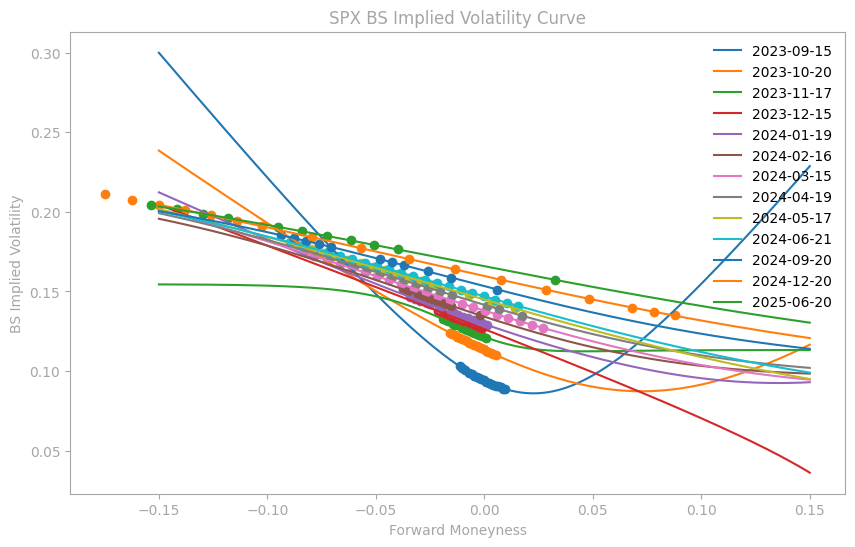

ValueError: Index data must be 1-dimensional

In [4]:
fwd_moneyness = fit_BS(implied_vol, implied_params[implied_params['Index'] == 'SPX']).get_fwd_mny()
bs_iv_curve_params = fit_BS(implied_vol, implied_params[implied_params['Index'] == 'SPX']).fit_BS_curve(fwd_moneyness, plot_curve=True)
bs_iv_surface = fit_BS(implied_vol, implied_params[implied_params['Index'] == 'SPX']).fit_surface(bs_iv_curve_params, plot_surface=True, type='wireframe')
display(fwd_moneyness.head())
display(bs_iv_curve_params.T)

## Convert BS Implied Volatility Surface to Local Volatility Surface

- use Dupire's formula to calculate the local volatility for each option
  $$
  \frac{\partial w}{\partial T} = v_L \left\{1 - \frac{y}{w}\frac{\partial w}{\partial y} + \frac{1}{4}\left(-\frac{1}{4}-\frac{1}{w}+\frac{y^2}{w^2}\right)\left(\frac{\partial w}{\partial y}\right)^2+\frac{1}{2}\frac{\partial^2 w}{\partial y^2}\right\}\\
  \text{where }w:=\text{ Black-Scholes implied variance},\quad y:= \ln\left(\frac{K}{F_T}\right), \quad v_L:=\text{ local variance}\\

  var_L = \displaystyle\frac{\frac{\partial w}{\partial T}}{1 - \frac{y}{w}\frac{\partial w}{\partial y} + \frac{1}{4}\left(-\frac{1}{4}-\frac{1}{w}+\frac{y^2}{w^2}\right)\left(\frac{\partial w}{\partial y}\right)^2+\frac{1}{2}\frac{\partial^2 w}{\partial y^2}}
  $$

## Trading Strategy

- if the implied volatility of an option is higher than the local volatility, then sell the option

## Backtesting

# To-do List
- after delete the rows with 0 volume, the moneyness with near expiration date is close to 0, it is hard to fit the implied volatility curve
- put call parity last price in 2023-09-15, the interest rate is negative. Using last price to calculate the risk-free rate fluctuates a lot. 
- if use put-call parity to get interest rate and forward price, what is the Dupire's formula?  
- how to use spot moneyness to fit the implied volatility curve?
- implied forawrd price is not a linear line. Is there anything wrong?
- Why the lowest point is not at the money option??

# Reference

[How to Determine Implied Dividend Yield-Derivative Valuation in Excel](https://derivvaluation.medium.com/how-to-determine-implied-dividend-yield-derivative-valuation-in-excel-1078a9bc1f7f)  
[SPX vs. SPXW Options: Understanding the Key Differences](https://insideoptions.io/spx-spxw-options-differences/)  
[Cubic Spline Interpolation](https://en.wikipedia.org/wiki/Spline_interpolation#Algorithm_to_find_the_interpolating_cubic_spline)  
[Estimation of Implied Interest Rates and Dividend Yields](../volatility_arbitrage/Reference/on_a_robust_estimation_of_option-implied_interest_rates_and_dividend_yields.pdf)  
[Put-Call-Forward Parity](https://analystnotes.com/cfa-study-notes-explain-put-call-forward-parity-for-european-options.html)  
[At-The-Money-Forward option approximation](https://quant.stackexchange.com/questions/35433/at-the-money-forward-option-approximation)  
[What is forward moneyness and how to calculate it?](https://quant.stackexchange.com/questions/43596/what-is-forward-moneyness-and-how-to-calculate-it)  
[At-The-Money Forward](https://www.fincyclopedia.net/derivatives/a/at-the-money-forward)  
[Sigmoid function详解](https://zhuanlan.zhihu.com/p/108641430)  
[Cubic Spline Interpolation](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Numerical_Methods_(Chasnov)/05%3A_Interpolation/5.03%3A_Cubic_Spline_Interpolation)  
[scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)  
[Dividend Swap Indices Access to equity income streams made easy](https://quantlabs.net/academy/download/free_quant_instituitional_books_/%5BBarclays%5D%20Dividend%20Swap%20Indices%20-%20Access%20to%20Equity%20Income%20Streams%20Made%20Easy.pdf#:~:text=Employing%20a%20methodology%20that%20is%20similar%20in%20principle,dividend%20swaps%20of%20a%20variety%20of%20yearly%20maturities.)